In [1]:
import os
import csv
import sys
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from pathlib import Path
import dotenv
dotenv.load_dotenv()
p_code = Path(os.environ.get("HOME_DIR"))
p_data = Path(os.environ.get("DATA_DIR"))

net = 'stepnet'
PATH_YANGNET = os.path.join(p_code,net) 
sys.path.insert(0, PATH_YANGNET)

from scipy.cluster import hierarchy
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
import matplotlib.patches as patches

from network import Model
from task import rules_dict

from scipy.stats import pearsonr
import json
from tools_lnd import rule_set_names, remove_ax_lines, remove_spines, remove_ticks, task_name_dict

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# ##################################################################
# #fig save path
# ##################################################################
fig = 'fig3'
figpath = os.path.join(p_code,'figs',fig,fig+'_BC')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [3]:
# ##################################################################
# #Find right model dir
# ##################################################################
file = 'LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1'
fig_name = 'fig3_5' 
m = os.path.join(p_data,fig_name,file)

lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
save_dir = os.path.join(m,lesion_folder)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
feature_names_master = cluster_var['tick_names'].astype(str)  # Convert to strings
feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in feature_names_master]

In [4]:
n_rnn_set = [128, 256, 512, 1024]

parameter_combinations = [
    (activation, rnn_type, w_init, n_rnn, data_folder)
    for activation in ['tanh','retanh','softplus',]
    for rnn_type in ['LeakyGRU','LeakyRNN',]
    for w_init in ['diag','randgauss']
    for n_rnn in n_rnn_set
    for data_folder in ['all','untrained']
]

In [5]:
color_set = {}
color_set['tanh'] = 'k'
color_set['retanh'] = 'dodgerblue'
color_set['softplus'] = 'orangered'
seed_set = [str(0),str(1),str(2)]
al = .1

/Users/lauradriscoll/Documents/data/flexible_multitask/suppfig4/LeakyGRU_tanh_diag_128_all_0/log.json
/Users/lauradriscoll/Documents/data/flexible_multitask/suppfig4/LeakyGRU_tanh_diag_128_all_1/log.json
/Users/lauradriscoll/Documents/data/flexible_multitask/suppfig4/LeakyGRU_tanh_diag_128_all_2/log.json
/Users/lauradriscoll/Documents/data/flexible_multitask/suppfig4/LeakyGRU_tanh_diag_128_untrained_0/log.json
/Users/lauradriscoll/Documents/data/flexible_multitask/suppfig4/LeakyGRU_tanh_diag_128_untrained_1/log.json
/Users/lauradriscoll/Documents/data/flexible_multitask/suppfig4/LeakyGRU_tanh_diag_128_untrained_2/log.json
/Users/lauradriscoll/Documents/data/flexible_multitask/suppfig4/LeakyGRU_tanh_diag_256_all_0/log.json
/Users/lauradriscoll/Documents/data/flexible_multitask/suppfig4/LeakyGRU_tanh_diag_256_all_1/log.json
/Users/lauradriscoll/Documents/data/flexible_multitask/suppfig4/LeakyGRU_tanh_diag_256_all_2/log.json
/Users/lauradriscoll/Documents/data/flexible_multitask/suppfig4/

(0.0, 49.0)

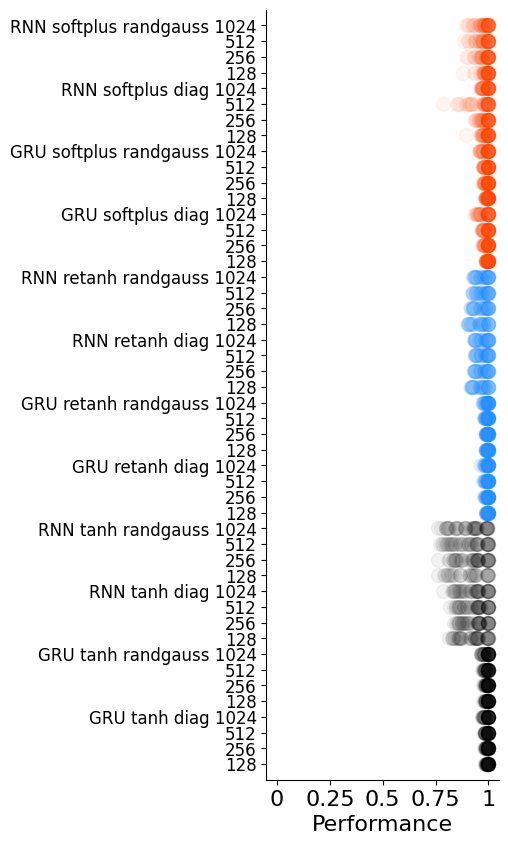

In [12]:
m = os.path.join(p_data,'suppfig4')
data_folder_set = ['all',]

fig = plt.figure(figsize=(3,10))
perf_ax = plt.subplot(111)
plt.rcParams.update({'font.size': 14})
data_folder_set = ['all','untrained']

# x-axis for plotting each networks correlation coeff, sparsity, performance
x_ind_counter = 0
ax1_xticks = []

perf_ax.plot(0,100,'ok',alpha = 1, markersize = 10,label = 'Trained')
perf_ax.plot(0,100,'ok',alpha = 1, markerfacecolor = 'w', markersize = 10,label = 'Untrained')

for activation, rnn_type, w_init, n_rnn, data_folder in parameter_combinations:
    

    c = color_set[activation]
    
    # x-axis and labelling bs
    if data_folder==data_folder_set[0]:
        x_ind_counter+=1
        markerfacecolor = c
        
        label = ' '.join([rnn_type[5:],activation,w_init,str(n_rnn)])
        
        if n_rnn==n_rnn_set[-1]:
            ax1_xticks.append(label)
        else:
            ax1_xticks.append(str(n_rnn))
    else:
        markerfacecolor = 'w'
    

    for seed in seed_set:
        file = '_'.join([rnn_type,activation,w_init,str(n_rnn),data_folder,str(seed)])
        fname = os.path.join(m,file, 'log.json')
        print(fname)

        if os.path.isfile(fname):
            
            with open(fname, 'r') as f:
                log_all = json.load(f)
                
            for r in rules_dict['all']:
                x = log_all['perf_'+r][-1]
                perf_ax.plot(x,x_ind_counter,'o',alpha = al/2,c = c, 
                                     markerfacecolor = markerfacecolor , markersize = 10)

perf_ax.set_yticks(range(1,len(ax1_xticks)+1))
perf_ax.set_yticklabels(ax1_xticks,rotation = 0,ha = 'right',fontsize = 12)
perf_ax.set_xticks([0,.25,.5,.75,1])
perf_ax.set_xticklabels([0,.25,.5,.75,1],rotation = 0,ha = 'center',fontsize = 16)
perf_ax.set_xlabel('Performance',fontsize = 16)
perf_ax.spines['top'].set_visible(False)
perf_ax.spines['right'].set_visible(False)
perf_ax.set_xlim((-.05,1.05))
perf_ax.set_ylim((0,len(ax1_xticks)+1))

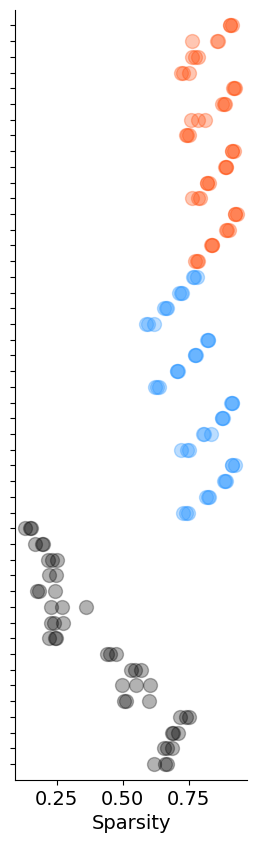

In [10]:
fig = plt.figure(figsize=(3,10))
sparsity_ax = plt.subplot(111)

# x-axis for plotting each networks correlation coeff, sparsity, performance
x_ind_counter = 0
ax1_xticks = []
len_te = len(feature_names_labels)
lesion_folder = 'lesion_fps_hierarchical_ward_maxclust_opt_clust'
m = os.path.join(p_data,'suppfig4')
data_folder_set = ['all',]
sparsity_threshold = .15
al = .3
    
for activation, rnn_type, w_init, n_rnn, data_folder in parameter_combinations:
    
    c = color_set[activation]
    if data_folder=='untrained':
        markerfacecolor = 'w'
    else:
        markerfacecolor = c

    # x-axis and labelling bs
    if data_folder==data_folder_set[0]:
        x_ind_counter+=1
        label = ' '.join([rnn_type,activation,w_init,str(n_rnn)])
        if len(ax1_xticks)==0:
            ax1_xticks = [label,]
        else:
            if n_rnn==1024:
                ax1_xticks.append(label)
            else:
                ax1_xticks.append(str(n_rnn))

    for seed in seed_set:
        file = '_'.join([rnn_type,activation,w_init,str(n_rnn),data_folder,str(seed)])
        
        #load atlas data
        fname = os.path.join(m,file,'cluster_var.npz')

        if os.path.isfile(fname):
            cluster_var = np.load(fname)
            D = cluster_var['D'].T
            
            sparsity_metric_num = len_te * (float(n_rnn) - len(D)) + np.sum(D.flatten() < sparsity_threshold)
            sparsity_metric_denom = len_te * float(n_rnn)
            sparsity_metric = sparsity_metric_num / sparsity_metric_denom
            
            sparsity_ax.plot(sparsity_metric,x_ind_counter,'o',alpha = al,c = c, 
                             markerfacecolor = markerfacecolor , markersize = 10)

sparsity_ax.set_yticks(range(1,len(ax1_xticks)+1))
sparsity_ax.set_yticklabels(ax1_xticks,rotation = 0,ha = 'right',fontsize = 16)
sparsity_ax.set_yticklabels([])
sparsity_ax.set_xlabel('Sparsity')
sparsity_ax.spines['top'].set_visible(False)
sparsity_ax.spines['right'].set_visible(False)
sparsity_ax.set_ylim((0,len(ax1_xticks)+1))

figname = 'Sparsity.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches = 'tight')

plt.show()

In [11]:
# set of networks to compare
rnn_type_set = ['LeakyRNN','LeakyGRU',]
activation_set = ['softplus','tanh','retanh',]
w_init_set = ['randgauss','diag',]
data_folder_set = ['all',]

tril_corr_mat_ave = {}

for rnn_type_i in range(len(rnn_type_set)):
    
    rnn_type = rnn_type_set[rnn_type_i]
    tril_corr_mat_ave[rnn_type] = {}
    
    for activation_i in range(len(activation_set)):
        
        activation = activation_set[activation_i]
        tril_corr_mat_ave[rnn_type][activation]= {}
        
        for w_init_i in range(len(w_init_set)):
            
            w_init = w_init_set[w_init_i]
            tril_corr_mat_ave[rnn_type][activation][w_init] = {}
            
            for data_folder in data_folder_set:
                
                tril_corr_mat_ave[rnn_type][activation][w_init][data_folder] = {}
                
                for n_rnn in [128,256,512,1024]:
                    
                    tril_corr_mat_ave[rnn_type][activation][w_init][data_folder][str(n_rnn)] = {}

                    for seed in seed_set:

                        file = '_'.join([rnn_type,activation,w_init,str(n_rnn),data_folder,str(seed)])
                        fname = os.path.join(m,file,'cluster_var.npz')
        
                        if os.path.isfile(fname)==False:
                            print('NEED TO FIND CLUSTERS ' + file)
                        else:

                            #load atlas data
                            cluster_var = np.load(fname)
                            D = cluster_var['D'].T
                            
                            feature_names_original = [cluster_var['tick_names'][s] for s in range(len(cluster_var['tick_names']))]
                            decoded_names = [str(name, encoding='utf-8') for name in feature_names_original]
                            feat_order = [decoded_names.index(s) for i,s in enumerate(feature_names_master)]
                            
                            X = D[:,feat_order]
                            corr_mat = np.corrcoef(X.T)

                            if seed==seed_set[0]:
                                corr_mat_stack = corr_mat[:,np.newaxis]
                            else:
                                corr_mat_stack = np.concatenate((corr_mat_stack,corr_mat[:,np.newaxis]),axis=1)

                    corr_mat_ave = np.mean(corr_mat_stack,axis = 1)
                    tril_corr_mat_ave[rnn_type][activation][w_init][data_folder][str(n_rnn)] = corr_mat_ave[np.tril_indices(len(corr_mat_ave),-1)]

NEED TO FIND CLUSTERS LeakyRNN_tanh_randgauss_128_all_1


NEED TO FIND CLUSTERS LeakyRNN tanh randgauss all 128 1


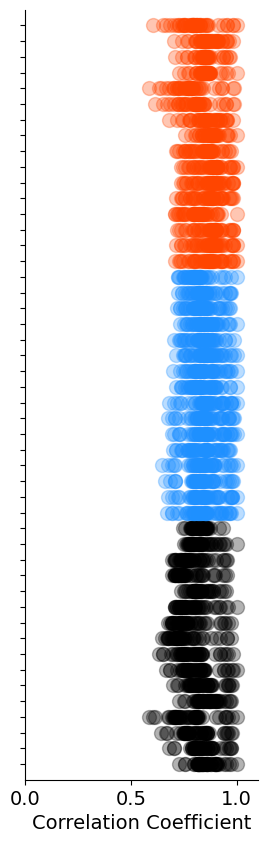

In [12]:
fig = plt.figure(figsize=(3,10))
corr_ax = plt.subplot(111)

# x-axis for plotting each networks correlation coeff, sparsity, performance
x_ind_counter = 0
ax1_xticks = []

for activation, rnn_type, w_init, n_rnn, data_folder in parameter_combinations:

    c = color_set[activation]
    if data_folder=='untrained':
        markerfacecolor = 'w'
    else:
        markerfacecolor = c

    # x-axis and labelling bs
    if data_folder==data_folder_set[0]:
        x_ind_counter+=1
        label = ' '.join([rnn_type,activation,w_init])
        if len(ax1_xticks)==0:
            ax1_xticks = [label,]
        else:
            ax1_xticks.append(label)

        for seed in seed_set:
    
            file = '_'.join([rnn_type,activation,w_init,str(n_rnn),data_folder,str(seed)])
            
            #load atlas data
            fname = os.path.join(m,file,'cluster_var.npz')
            
            if os.path.isfile(fname)==False:
                print('NEED TO FIND CLUSTERS ' + ' '.join([rnn_type,activation,w_init,data_folder,str(n_rnn),seed]))
            else:
    
                #load atlas data
                cluster_var = np.load(fname)
                D = cluster_var['D'].T
                feature_names_original = [cluster_var['tick_names'][s] for s in range(len(cluster_var['tick_names']))]
                decoded_names = [str(name, encoding='utf-8') for name in feature_names_original]
                feat_order = [decoded_names.index(s) for i,s in enumerate(feature_names_master)]
                X = D[:,feat_order]
    
                corr_mat = np.corrcoef(X.T)
    
                if seed==seed_set[0]:
                    corr_mat_stack = corr_mat[:,np.newaxis]
                else:
                    corr_mat_stack = np.concatenate((corr_mat_stack,corr_mat[:,np.newaxis]),axis=1)
    
        if data_folder=='all':
            corr_mat_ave = np.mean(corr_mat_stack,axis = 1)
            tril_corr_mat_master = tril_corr_mat_ave[rnn_type][activation][w_init][data_folder][str(n_rnn)]
    
            for activation_sub, rnn_type_sub, w_init_sub, n_rnn_sub, data_folder_sub in parameter_combinations:

                
                if data_folder_sub==data_folder_set[0]:
                    tril_corr_mat_sub = tril_corr_mat_ave[rnn_type_sub][activation_sub][w_init_sub][data_folder_sub][str(n_rnn_sub)]
        
                    corr, pval = pearsonr(tril_corr_mat_master,tril_corr_mat_sub)
        
                    if data_folder_sub=='untrained':
                        markerfacecolor = 'w'
                    else:
                        markerfacecolor = c
        
                    if corr!=1:
                        corr_ax.plot(corr,x_ind_counter,'o',c=c,alpha = al,
                                     markerfacecolor = markerfacecolor, markersize = 10)
    
        corr_mat_stack = []

# visualization beautification bs
corr_ax.set_yticks(range(1,len(ax1_xticks)+1))
corr_ax.set_yticklabels(ax1_xticks,rotation = 90,ha = 'center',fontsize = 16)
corr_ax.set_yticklabels([])
corr_ax.set_xlabel('Correlation Coefficient')
corr_ax.set_xlim((0,1.1))
corr_ax.spines['top'].set_visible(False)
corr_ax.spines['right'].set_visible(False)
corr_ax.set_ylim((0,len(ax1_xticks)+1))


figname = 'Corr_coeff.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches = 'tight')

plt.show()


In [13]:
# Define the directory containing the .npy files
data_dir = "/Users/lauradriscoll/Documents/data/flexible_multitask/fig3_5/3bc"  # Replace with your directory path

# Loop through all files in the directory
for filename in os.listdir(data_dir):
  if filename.endswith(".npy"):  # Check for .npy extension
    # Construct the full path to the file
    filepath = os.path.join(data_dir, filename)

    # Load the data from the .npy file
    data = np.load(filepath)

    # Extract filename without extension for the CSV filename
    csv_filename = os.path.splitext(filename)[0] + ".csv"

    # Open the CSV file for writing
    with open(os.path.join(figpath, csv_filename), 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      
      # Write the data to the CSV file
      writer.writerows(data.tolist())  # Convert to list for writing

In [14]:
def plot_epoch_labels(ax, epoch_binary, which_axes = 'y', ms = .9):
    
    e_set = ['stim1','stim2','delay1','delay2','go1']
    e_color = plt.get_cmap('terrain')

    yl = np.max(ax.get_ylim())+2
    xl = np.max(ax.get_xlim())+2
    
    for ei in range(len(e_set)):
        e_name = e_set[ei]
        where = np.where(epoch_binary[e_name])[0]-.7
        c = e_color(ei/len(e_set))
        
        if 'y' in which_axes:
            
            ax.plot(np.where(epoch_binary[e_name])[0],
                     yl*np.ones(np.sum(epoch_binary[e_name])),'s',
                     color = c,markersize = ms,label = e_name)

            for w in where:
            
                rect = patches.Rectangle((w, yl), 1, 3,linewidth=ms, edgecolor=c, facecolor=c)
                ax.add_patch(rect)
            
        if 'x' in which_axes:
            
            ax.plot(xl*np.ones(np.sum(epoch_binary[e_name])),
                     np.where(epoch_binary[e_name])[0],'s',
                     color = c,markersize = ms,label = e_name)
            
            for w in where:
                rect = patches.Rectangle((xl, w), 3, 1,linewidth=ms, edgecolor=c, facecolor=c)
                ax.add_patch(rect)
            
            
def plot_epoch_rects(ax, epoch_binary, e_set, which_axes = 'y', rect_height = 1, rect_width = 58, ll = []):
    e_color = plt.get_cmap('terrain')

    if len(ll)>0:
        xl = ll[1]
        yl = ll[0]
    else:
        yl = np.max(ax.get_ylim())+2
        xl = np.max(ax.get_xlim())+2

        
    for ei in range(len(e_set)):
        e_name = e_set[ei]
        c = e_color(ei/len(e_set))
        
        if 'y' in which_axes:
            
            for ind in np.where(epoch_binary[e_name])[0]:
                rect=mpatches.Rectangle((ind-.5,yl),rect_height,rect_width,
                                        fill=True,color=c,facecolor=c,alpha = .3,clip_on=False)
                plt.gca().add_patch(rect)
            
        if 'x' in which_axes:
            
            for ind in np.where(epoch_binary[e_name])[0]:
                rect=mpatches.Rectangle((xl,ind-.5),rect_height,rect_width,
                                        fill=True,color=c,facecolor=c,alpha = .3,clip_on=False)
                plt.gca().add_patch(rect)
        

In [15]:
def make_pretty_corr_mats(corr_mat_ave):

    fig = plt.figure(figsize=(3.5,3.5))
    ax = plt.subplot(111)
    plt.imshow(corr_mat_ave,cmap= 'Greys',clim = (-.5,1))
    
    feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in feature_names_master]
    epoch_binary = {}
    for e_name in ['delay1','delay2','go1','stim1','stim2']:
        epoch_binary[e_name] = [feat_name.rsplit(' ', 1)[-1]==e_name for 
                                feat_name in feature_names_master]
    plot_epoch_labels(ax,epoch_binary,which_axes = 'xy')
        
    dmc_where = np.where([feat_name=='DMC delay1' for feat_name in feature_names_master])[0][0]-.5
    rect = patches.Rectangle((dmc_where, len(feature_names_master)), 2, 6, 
                             linewidth=1.7, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    rect = patches.Rectangle((len(feature_names_master), dmc_where), 6, 2, 
                             linewidth=1.7, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    
    memgo_where = np.where([feat_name=='Dly DM 1 delay2' for feat_name in feature_names_master])[0][0]-.5
    rect = patches.Rectangle((memgo_where,len(feature_names_master)), 2, 6, 
                             linewidth=1.7, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    rect = patches.Rectangle((len(feature_names_master),memgo_where), 6, 2, 
                             linewidth=1.7, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    
    plt.ylabel('Task Periods',fontsize = 16)
    plt.xlabel('Task Periods',fontsize = 16)
    remove_ax_lines(ax)
    ax.set_yticks([])
    ax.set_xticks([])
    
    remove_ticks(ax)
    remove_spines(ax)
    
    figname = '_'.join([rnn_type,activation,w_init,data_folder,seed])+'.pdf'
    full_figpath = os.path.join(figpath,'corr_mats_labels')
    if not os.path.exists(full_figpath):
        os.makedirs(full_figpath)
    plt.savefig(os.path.join(full_figpath,figname),bbox_inches = 'tight')
    plt.show()



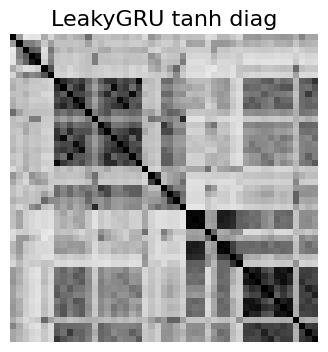

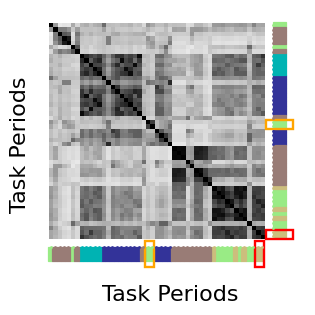

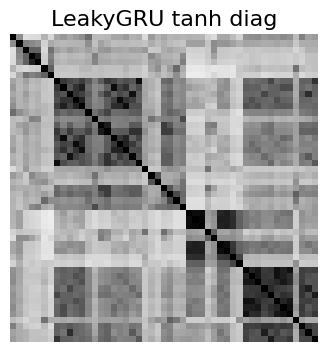

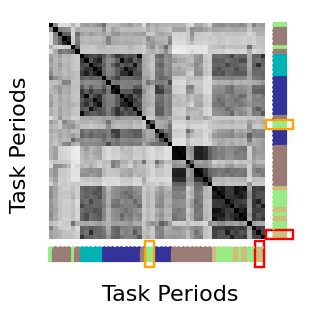

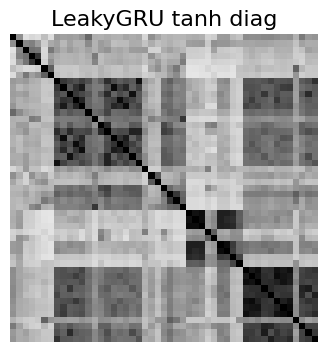

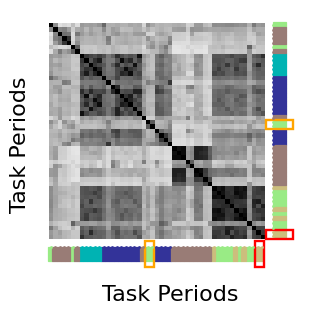

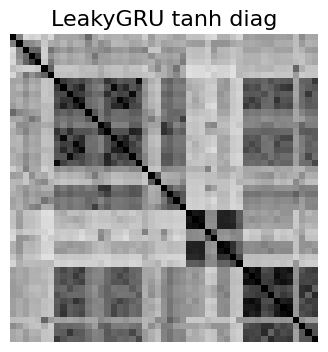

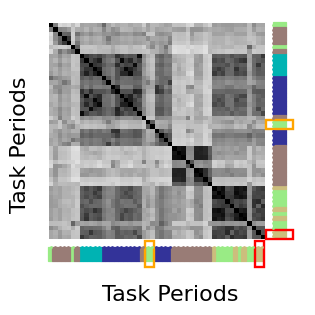

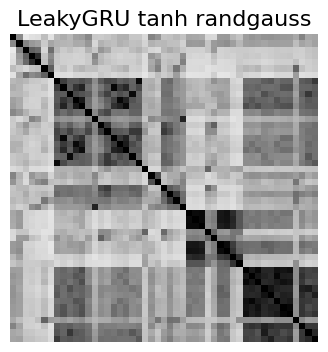

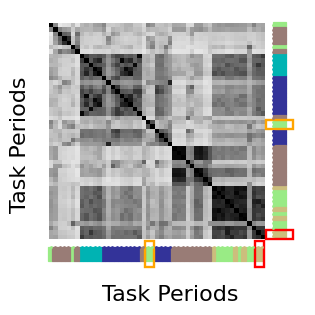

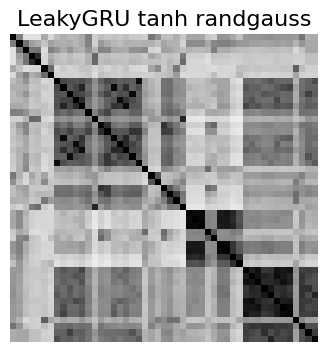

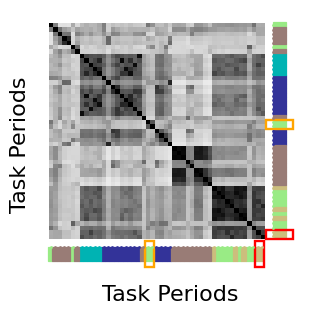

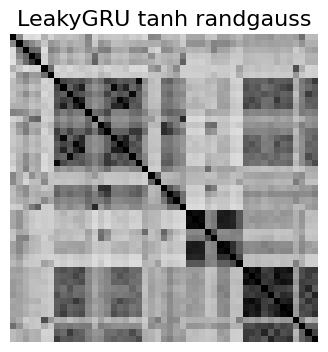

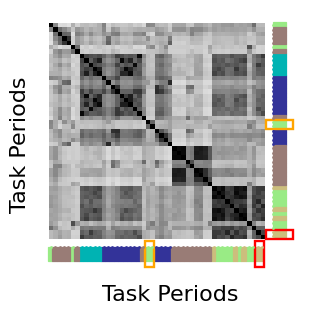

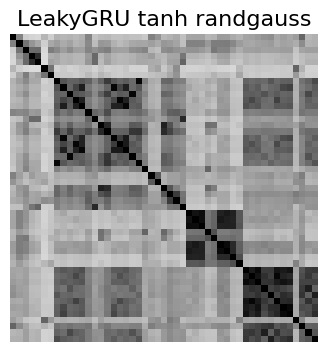

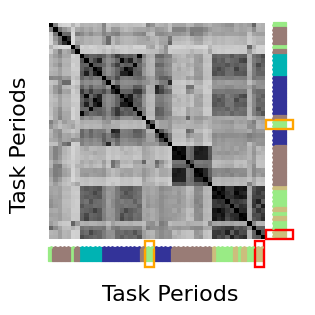

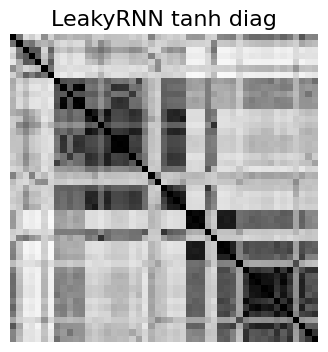

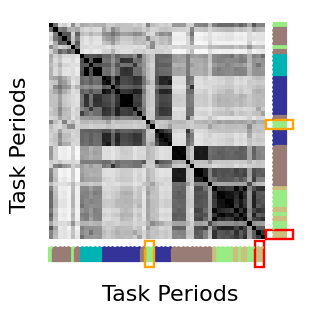

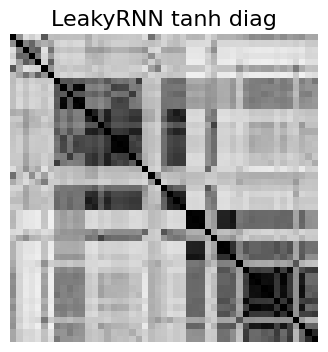

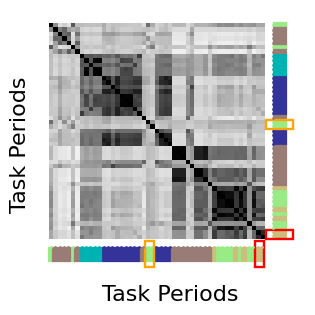

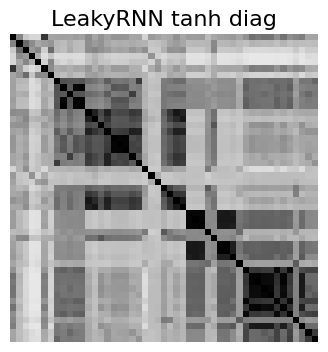

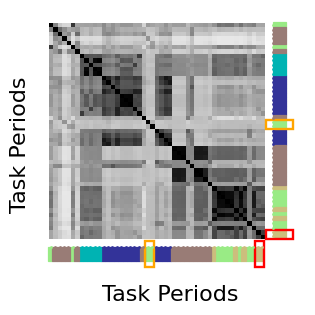

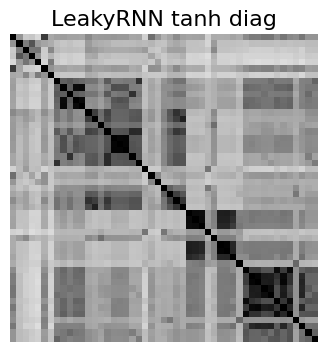

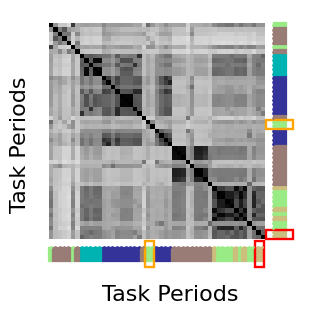

NEED TO FIND CLUSTERS LeakyRNN tanh randgauss all 128 1


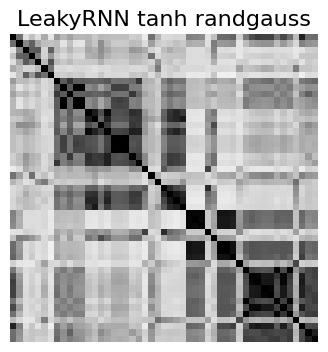

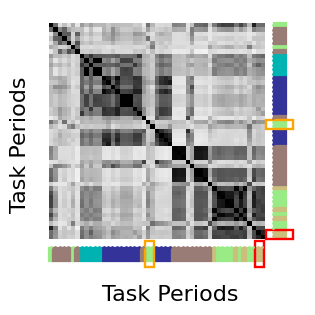

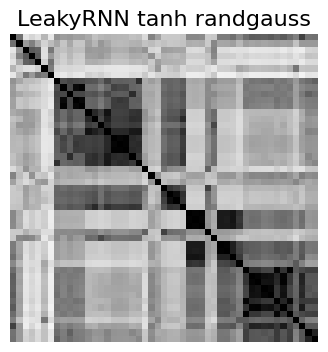

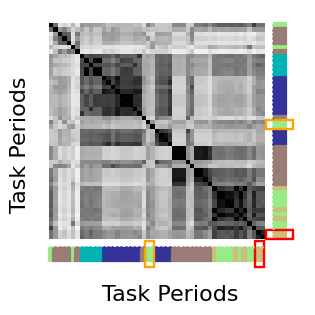

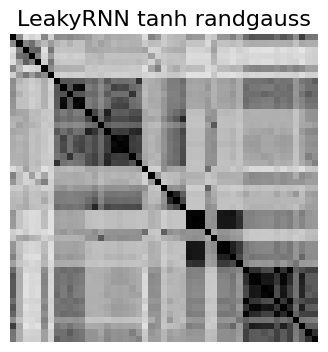

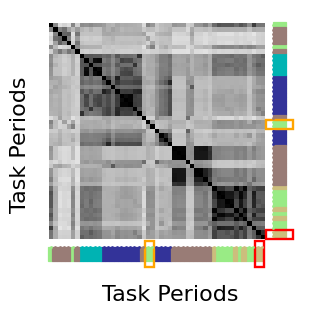

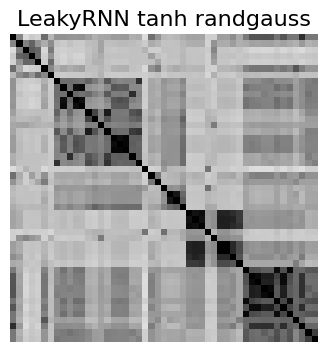

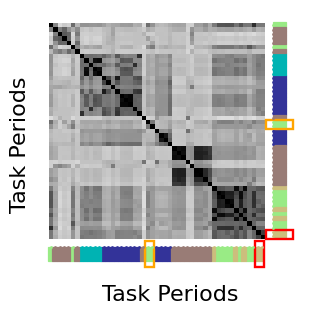

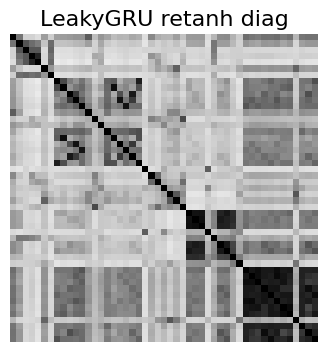

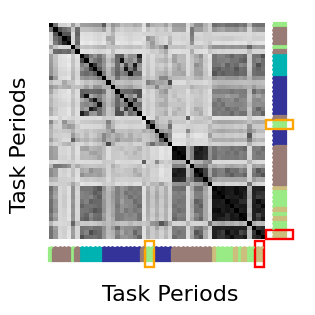

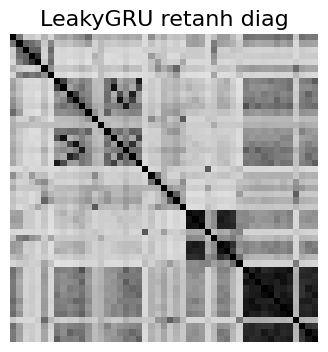

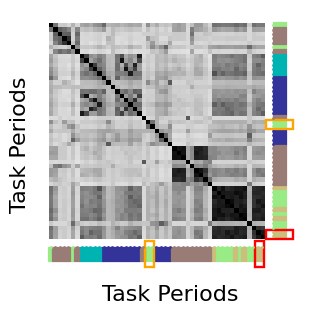

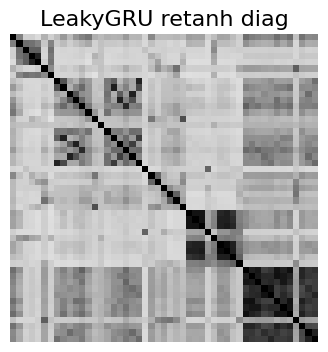

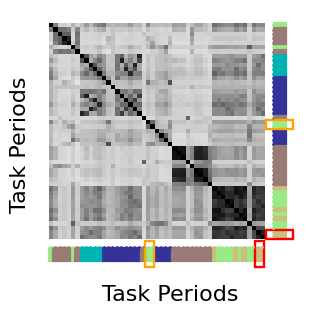

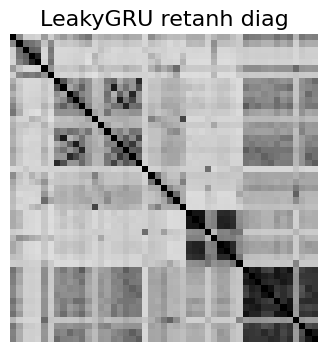

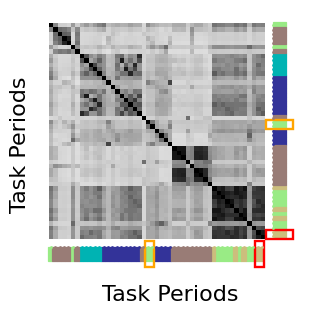

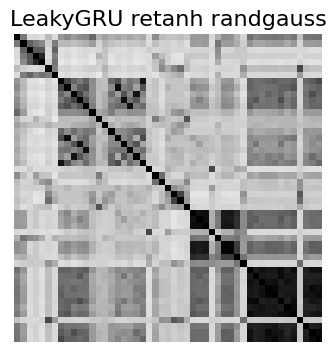

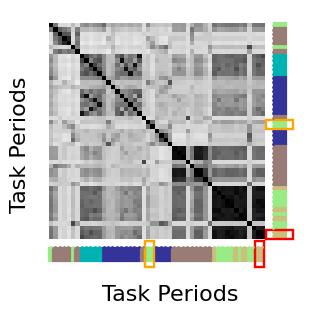

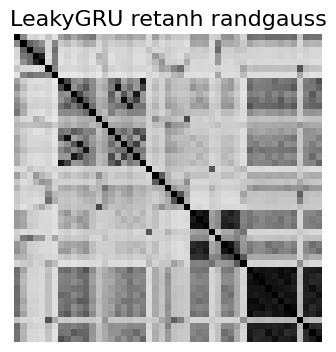

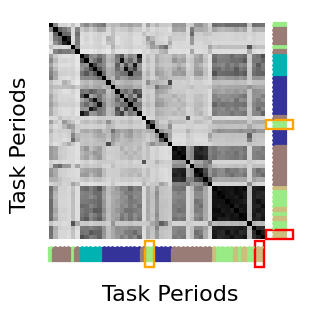

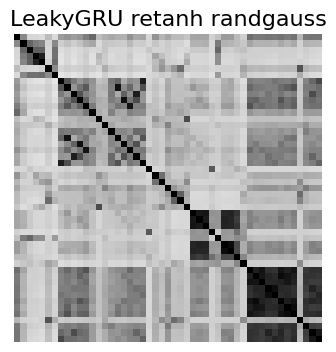

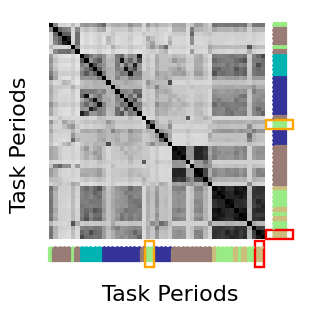

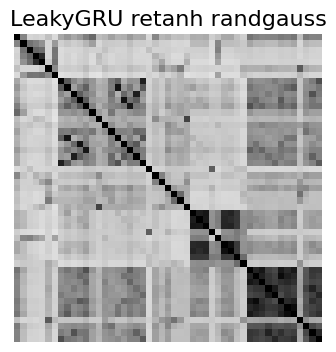

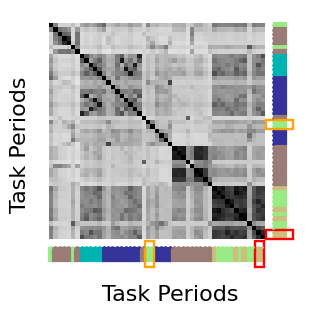

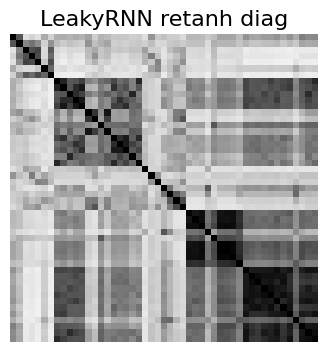

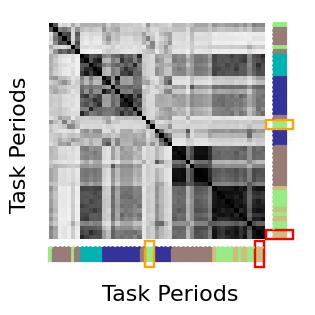

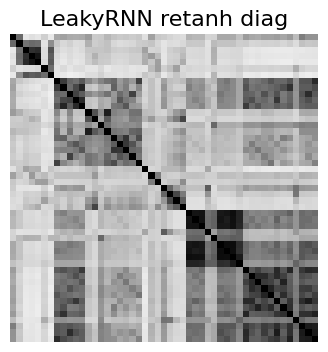

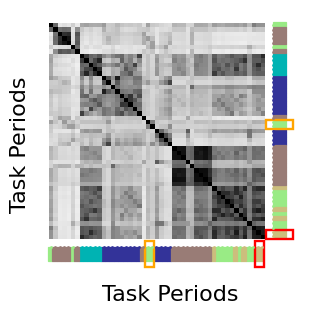

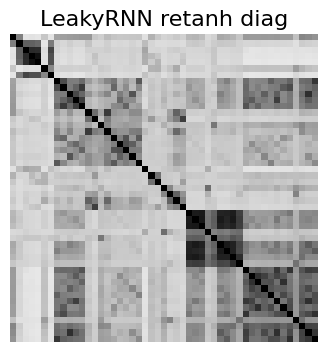

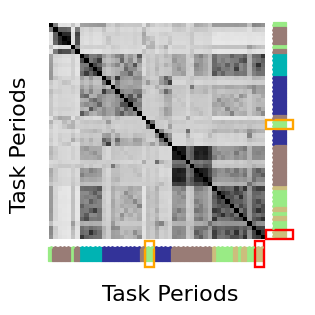

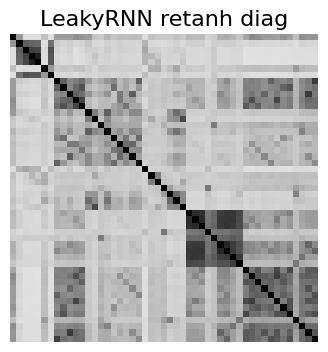

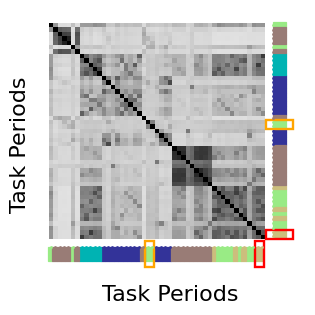

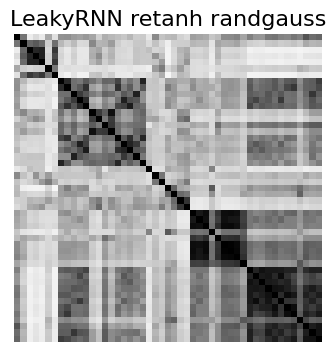

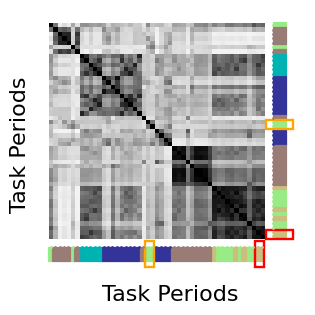

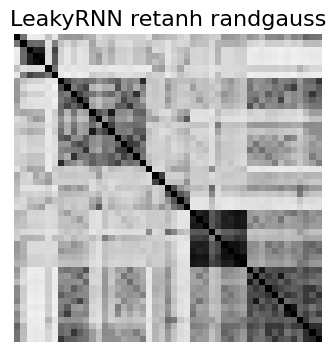

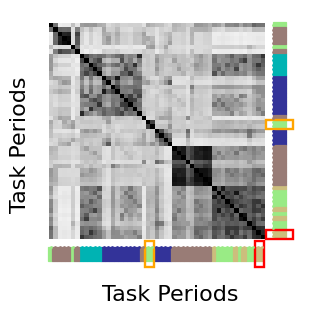

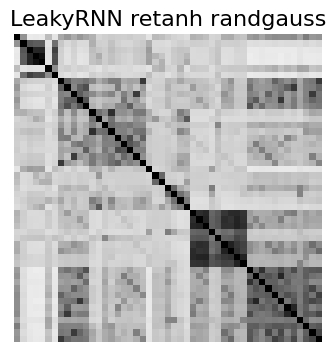

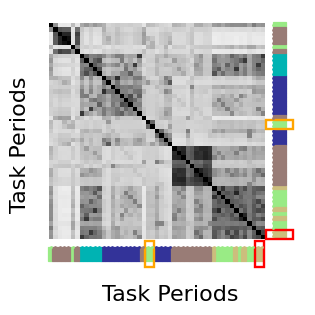

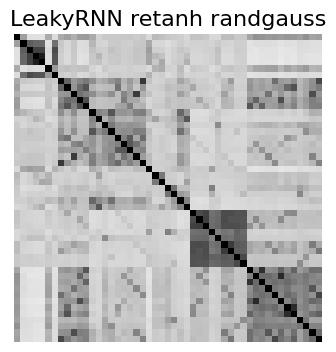

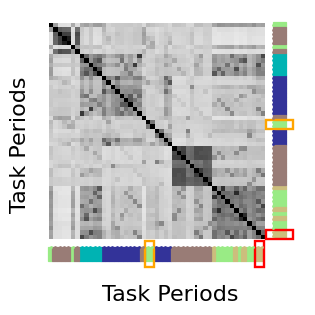

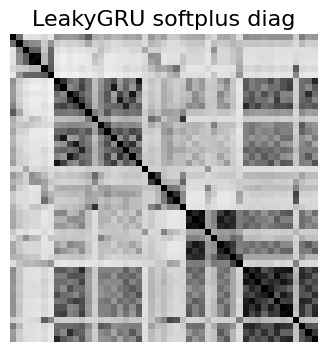

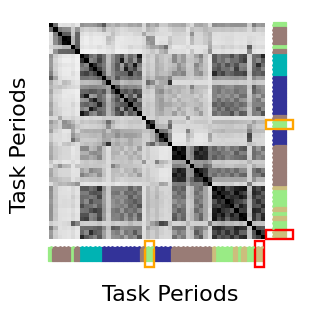

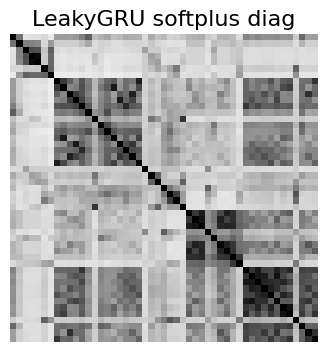

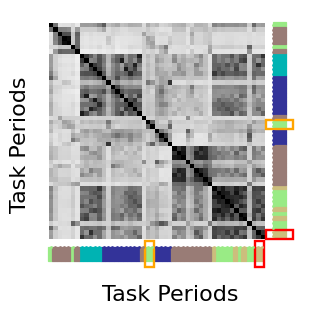

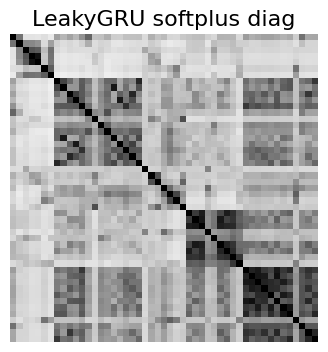

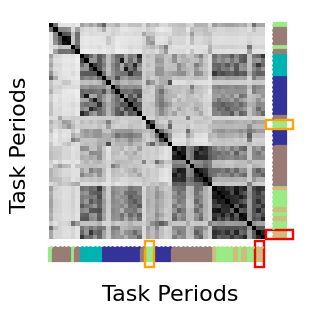

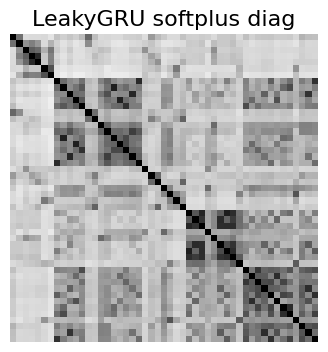

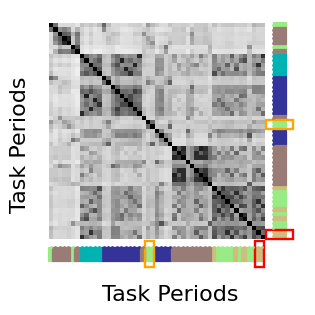

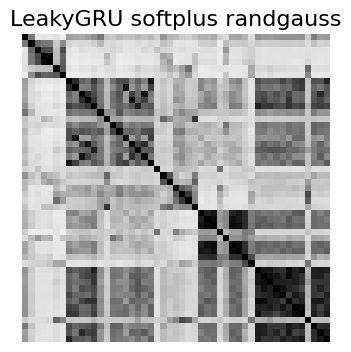

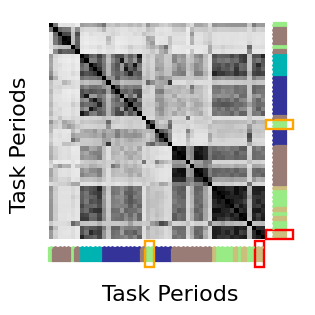

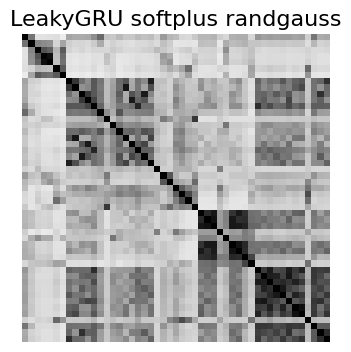

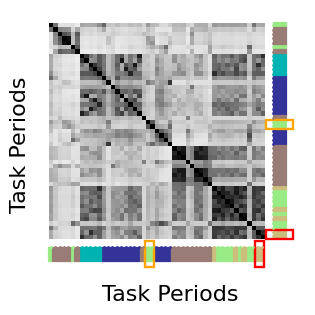

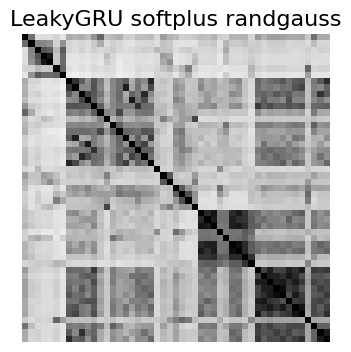

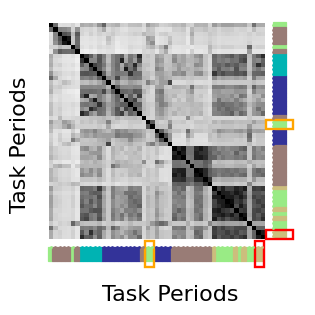

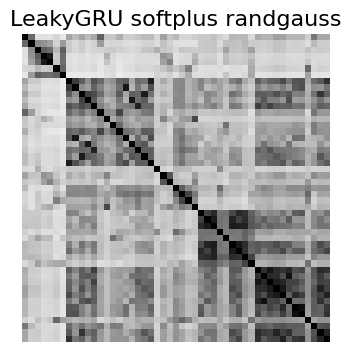

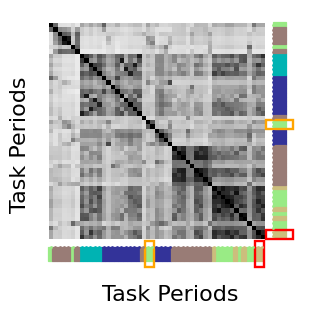

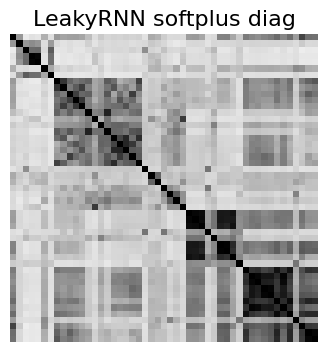

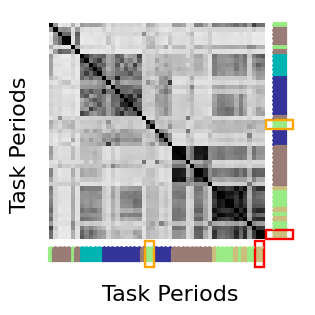

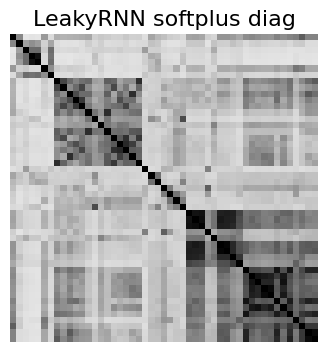

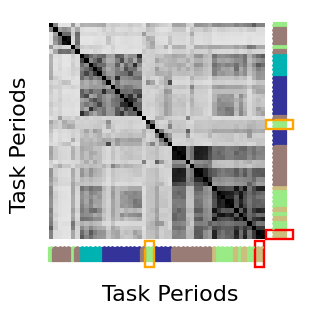

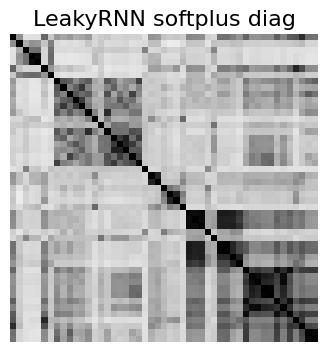

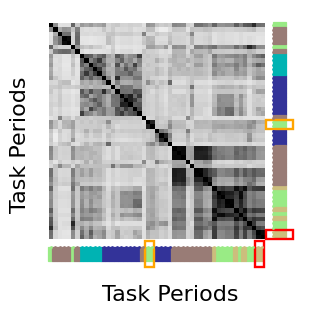

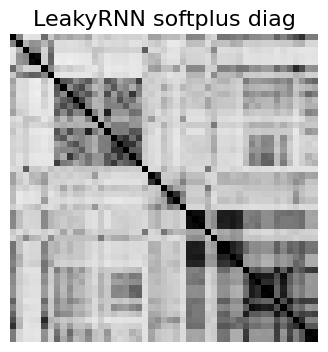

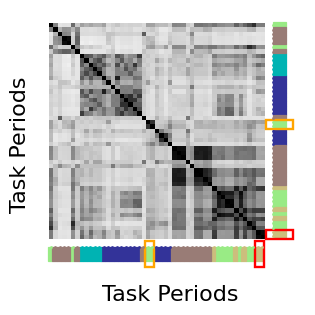

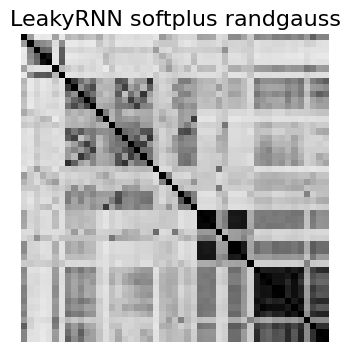

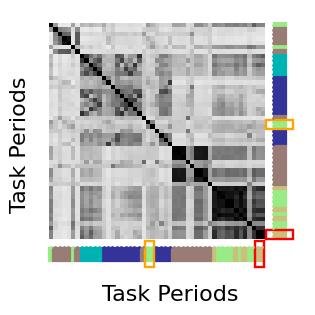

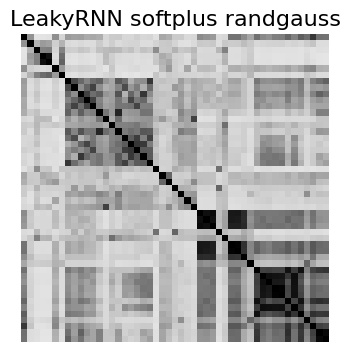

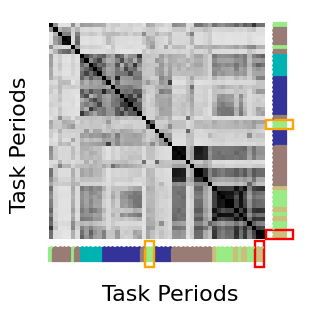

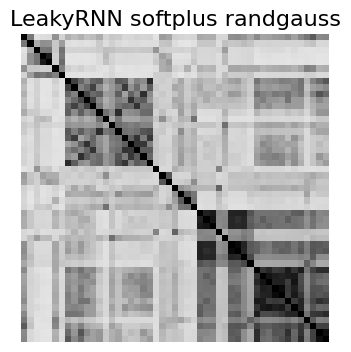

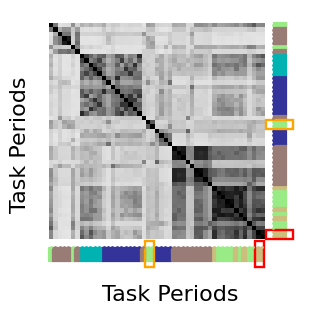

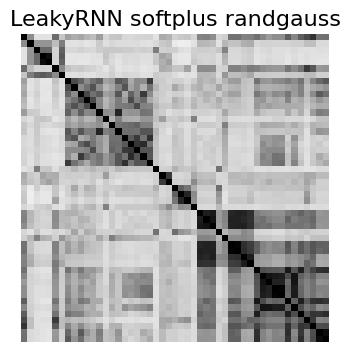

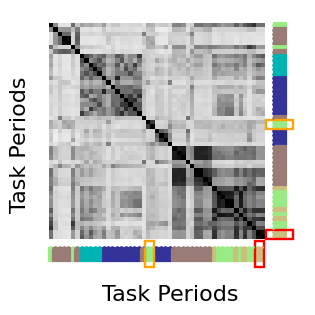

In [19]:
len_te = len(feature_names_labels)
epoch_binary = {}
for e_name in ['delay1','delay2','go1','stim1','stim2']:
    epoch_binary[e_name] = [feat_name.rsplit(' ', 1)[-1]==e_name for 
                            feat_name in feature_names_master]
    
for activation, rnn_type, w_init, n_rnn, data_folder in parameter_combinations:

    if data_folder == data_folder_set[0]:
        corr_mat_stack = []
        for seed in seed_set:
            
            file = '_'.join([rnn_type,activation,w_init,str(n_rnn),data_folder,str(seed)])
    
            #load atlas data
            fname = os.path.join(m,file,'cluster_var.npz')
            
            if os.path.isfile(fname)==False:
                print('NEED TO FIND CLUSTERS ' + ' '.join([rnn_type,activation,w_init,data_folder,str(n_rnn),seed]))
            else:
    
                #load atlas data
                cluster_var = np.load(fname)
                D = cluster_var['D'].T
                feature_names_original = [cluster_var['tick_names'][s] for s in range(len(cluster_var['tick_names']))]
                decoded_names = [str(name, encoding='utf-8') for name in feature_names_original]
                feat_order = [decoded_names.index(s) for i,s in enumerate(feature_names_master)]
                X = D[:,feat_order]
    
                corr_mat = np.corrcoef(X.T)
    
                if seed==seed_set[0]:
                    corr_mat_stack = corr_mat[:,np.newaxis]
                else:
                    corr_mat_stack = np.concatenate((corr_mat_stack,corr_mat[:,np.newaxis]),axis=1)
    
        corr_mat_ave = np.mean(corr_mat_stack,axis = 1)
    
        fig = plt.figure(figsize=(4,4))
        ax = plt.subplot(111)
        label = ' '.join([rnn_type,activation,w_init])
        plt.title(label, fontsize = 16)
        plt.imshow(corr_mat_ave,cmap= 'Greys',clim = (-.5,1))
        remove_ax_lines(ax)
        ax.set_yticks([])
        ax.set_xticks([])
        
        figname = '_'.join([rnn_type,activation,w_init,data_folder])+'.pdf'
        full_figpath = os.path.join(figpath,'corr_mats_nolabels')
        if not os.path.exists(full_figpath):
            os.makedirs(full_figpath)
        plt.savefig(os.path.join(full_figpath,figname))
        plt.show()
    
        make_pretty_corr_mats(corr_mat_ave)
        
    